In [275]:
# make the screen bigger!

from IPython.display import display, HTML

display(HTML(data="""   <style>     div#notebook-container    { width: 100%; }     div#menubar-container     { width: 85%; }     div#maintoolbar-container { width: 99%; } </style>
"""))

# import all our libraries (if this cell throws an error you may need to reinstall a library)
import os
import pandas as pd
import shutil   
import re
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats

%matplotlib notebook


### Import custom functions

In [276]:
from datetime import date, datetime, timedelta

%run Functions/Funcs.py

# Read in and process the raw data files in all their terrible messy gloriousness
- 1: takes files of different formats, .dat, .csv, and .xlsx and converts to csv
- 2: cleans non-uniform headers, based on a time or date column    
- 3: standardizes data headers 
- 4: creates formatted csv files with all correct formats to be processed further

Note in the " this block standardizes all the columns to the same names" block, All possible iterations of the column names need to be listed or else the data will not be copied


In [277]:
#### Paths
pristine_raw_data       = os.path.join('..', 'Raw_data/Weather_stations/Raw_data')

Raw_data_copy  = os.path.join('.', 'Workspace/Raw_data_copy')
if not os.path.exists(Raw_data_copy):  os.makedirs(Raw_data_copy)      # create the folder if not exist

Formatted_data = os.path.join('.', 'Workspace/Formatted_raw_data')
if not os.path.exists(Formatted_data):  os.makedirs(Formatted_data)      # create the folder if not exist

    
#### Parameters
# string to look for is anything with "time" in it for taking out trash headings
p = re.compile('time', re.IGNORECASE) 
# Final data headings
headings = ['DateTime', 'SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']


#### Workflow


# make a pristine copy of the raw data and clear the formatted data directoy, deleting everything that may have been created before
for f in os.listdir(Raw_data_copy):
    os.remove(os.path.join(Raw_data_copy, f))          # clean raw data directory

for f in os.listdir(Formatted_data):
    os.remove(os.path.join(Formatted_data, f))          # clean raw data directory

for f in os.listdir(pristine_raw_data): 
    shutil.copy(os.path.join(pristine_raw_data, f), Raw_data_copy) # restock directory     
    
    
    
# Change any dat files to csv     (they are just csvs it looks like so rename them locally)
for i in os.listdir(Raw_data_copy):
    if i.endswith('.dat'):
        nam = os.path.splitext(i)[0]
        if not os.path.exists(os.path.join(Raw_data_copy, nam+".csv")):
            os.rename(os.path.join(Raw_data_copy, i), os.path.join(Raw_data_copy, nam+".csv"))
            print("Converting {} to {}.csv".format(i, nam))

# Process each excel file into csv file 
for i in os.listdir(Raw_data_copy): 
    
    if i.endswith('.xlsx'):
        thefile = os.path.join(Raw_data_copy, i)
        # clean the header and read in  the data  (using one of my custom functions) 
        data = xls_cleaner(thefile)              
        nam = i.split(".")[0]                    # remove the .xls
        
        # save to same folder but as a csv now.
        data.to_csv(os.path.join(Raw_data_copy, nam+'.csv'), encoding='utf-8') # note: this step is where duplicate files will dissapear as they will be named the exact same thing and then ocerwitten by the loop 
        print("Converting {} to {}.csv".format(i, nam))


        
# Process each csv file into a clean csv file save in alternate directory

for i in os.listdir(Raw_data_copy):        
    # For the csvs that have not been cleaned
    if i.endswith('.csv'):
        print("Working on {}".format(i)) 
        tempdata_good =pd.DataFrame(columns = headings)                                  # blank dataframe to write to

        with open(os.path.join(Raw_data_copy, i), 'r') as f_in:                 # open file 
            text_line_data = f_in.read().splitlines(True)                       # temporary object for finding header

        for skips in range(0,6):
            matcher = p.search(text_line_data[skips])                           # find the row that has the word time in it
            if matcher:
                rows2skip = skips                                               # ID the number of rows to skip to make the time row the header row
        tempdata = pd.read_csv(os.path.join(Raw_data_copy, i), skiprows=rows2skip)  # read in dataset, with the correct header

        tempdata.columns = tempdata.columns.str.strip()                         # remove any whitespace in the collumn headdings 

    # this block standardizes all the columns to the same names
        for col in tempdata.columns:
            if col in ("TIMESTAMP","Timestamp", "Date and Time" ):
                tempdata =  tempdata.rename(columns={col: "DateTime"} )
            if col in ("TMP" , "Air Temp (F)", "AirTF_Avg"):
                tempdata =  tempdata.rename(columns={col: "TMP_F"} )
            if col in ("HMD", "RH", "Relative Humidity"):
                tempdata =  tempdata.rename(columns={col: "HMD_pct"} )
            if col in ("SRD", "Solar Rad (W_AVG)", "SlrW_Avg"):
                tempdata =  tempdata.rename(columns={col: "SRD_wpm2"} )
            if col in ("RNF", "Rain_in_Tot", "Rain (in)"):
                tempdata =  tempdata.rename(columns={col: "RNF_in"} )
            if col in ("WND", "WindDir_D1_WVT", "Wind Direction (D1)"):
                tempdata =  tempdata.rename(columns={col: "WND_deg"} )       
            if col in ("WNS", "Wind Speed (MPH)", "WS_mph_S_WVT"):
                tempdata =  tempdata.rename(columns={col: "WNS_mph"} )  

    # This block takes out unwanted headings and resets index
        try:
            for col2 in headings:
                tempdata_good[col2] = tempdata[col2]                                    # select only the headings we want
        except:                                                    # this except pass keeps it from hanging up where there are missing columns like in the ASPA SR station   
            pass
        tempdata_good = tempdata_good.reset_index(drop=True)                       # reset the row index to start from 0
        
        tempdata_good['DateTime'] = pd.to_datetime(tempdata_good['DateTime'], errors='coerce')      # string date to real date
        tempdata_good = tempdata_good[tempdata_good['DateTime'].notnull()]                          # Apparemntly sonme of the CR300 datafiles make some dumb extra rows behind the timestamp column

    #this names the data key based on its first and last date (if there is a repeat file it will not make a repeat data entry)
        i = i.replace(" ", "_")
        i = i.replace("-", "_")                # this takes any dashes and underscores turns them to spaces so that the first word can be used for the name even is there is a dash

    # note: some of the time stamps from the stations are not perfectily on 15 mins, this rounds to the nearest 15    

        tempdata_good['DateTime'] = tempdata_good['DateTime'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))

        nam = i.split("_")[0] +'_'+ str(tempdata_good['DateTime'].iloc[0]).split(" ")[0] +'_to_'+str(tempdata_good['DateTime'].iloc[-1]).split(" ")[0]
        
        data = tempdata_good.copy()
            
        data.to_csv(os.path.join(Formatted_data, nam+'.csv'), encoding='utf-8', index=False) # note: this step is where duplicate files will dissapear as they will be named the exact same thing and then ocerwitten by the loop 
        print("Saved as {}".format(nam+'.csv'))         


Converting Aasu-CR300wx.dat to Aasu-CR300wx.csv
Converting Afono-wx-060519.dat to Afono-wx-060519.csv
Converting Poloa-CR300wx.dat to Poloa-CR300wx.csv
Converting Vaipito-CR300wx.dat to Vaipito-CR300wx.csv
Converting Aasu -Weather-0616161.xlsx to Aasu -Weather-0616161.csv
Converting Aasu -Weather-0616162.xlsx to Aasu -Weather-0616162.csv
Converting Aasu Downloaded01182016.xlsx to Aasu Downloaded01182016.csv
Converting Aasu Wx 020917.xlsx to Aasu Wx 020917.csv
Converting Aasu Wx 092816.xlsx to Aasu Wx 092816.csv
Converting Aasu Wx 2016 & Notes (2).xlsx to Aasu Wx 2016 & Notes (2).csv
Converting Aasu Wx 2016 & Notes (3).xlsx to Aasu Wx 2016 & Notes (3).csv
Converting Aasu Wx 2016 & Notes.xlsx to Aasu Wx 2016 & Notes.csv
Converting Aasu _Downloaded10072015.xlsx to Aasu _Downloaded10072015.csv
Converting Aasu _Wx_071916.xlsx to Aasu _Wx_071916.csv
Converting Aasu-Wx-013018.xlsx to Aasu-Wx-013018.csv
Converting Afono-Wx-013018.xlsx to Afono-Wx-013018.csv
Converting Afono-Wx-102418.xlsx to A

Saved as Poloa_2017-02-16_to_2017-05-19.csv
Working on Poloa Wx 070917.csv
Saved as Poloa_2017-02-16_to_2017-06-09.csv
Working on Poloa Wx 091317.csv
Saved as Poloa_2017-01-01_to_2017-08-31.csv
Working on Poloa Wx 100316.csv
Saved as Poloa_2016-08-18_to_2016-10-03.csv
Working on Poloa Wx 2016 & Notes (2).csv
Saved as Poloa_2016-01-01_to_2016-08-18.csv
Working on Poloa Wx 2016 & Notes (3).csv
Saved as Poloa_2016-01-01_to_2016-11-28.csv
Working on Poloa Wx 2016 & Notes.csv
Saved as Poloa_2016-01-01_to_2016-12-15.csv
Working on Poloa Wx-110217.csv
Saved as Poloa_2017-06-01_to_2017-10-23.csv
Working on Poloa _Downloaded01192016.csv
Saved as Poloa_2015-07-21_to_2016-01-19.csv
Working on Poloa _Downloaded10072015.csv
Saved as Poloa_2015-07-21_to_2015-07-22.csv
Working on Poloa _Downloaded10072015_jul_oct.csv
Saved as Poloa_2015-07-21_to_2015-10-06.csv
Working on Poloa _Wx_071916.csv
Saved as Poloa_2016-06-08_to_2016-07-18.csv
Working on Poloa-CR300wx.csv
Saved as Poloa_2019-06-17_to_2020-05-

# Data Exploration Workflow

In [278]:
# Read in each file as a pandas dataframe and store in a pythoon Dic
All_data = {}
for file in os.listdir(Formatted_data):
    try:
        file_name = file.split(".")[0]
        datas = pd.read_csv(os.path.join(Formatted_data, file), parse_dates=['DateTime'])
        All_data[file_name] = datas   # all data now houses all the formatted files in a dictionary form use len(All_data.keys()) to check number of files included
    except:  
        print("Problem_with   -   "+file)

### Create a master dataframe for each station by concating all the individual files for each station 

In [279]:
listos = list(All_data.keys())   # list of each file in the directory

headings_no_date = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

AasuWx = {}                      # empty dictionaries for each station, add more of these to add statoins
AlavaWx = {}                     # note these are dictionaries of each individual file arranged by station name, thus these are a bunch of individual files
PoloaWx = {}
VaipitoWx = {}
FagaituaWx = {}
AfonoWx = {}
ASPAsolarWx ={}

try:
    r = re.compile('[Aa]asu')                       # find things that have this substring in them
    Aasu_files = list(filter(r.match, listos))      # from the list of all the files that exist  (listos)
except: 
    print("Problem_matching - Aasu")
    
try:
    for a in Aasu_files:                            # for each of those files add it to the dictionary one by one    
        AasuWx[a] = All_data[a]                     # this line populates the file dictionaries
        for h in headings_no_date:
            AasuWx[a][h]=AasuWx[a][h].astype(float)                                  # for some reason the data was coming is as strings so have to convert it to floats...
    AasuMaster = pd.concat(AasuWx.values()).drop_duplicates(subset='DateTime')  # This is now a dataframe for the station (stick all the files together into one, and drop any overlap)
    AasuMaster = AasuMaster.sort_values('DateTime')                             # This now sorts in date order
    AasuMaster = AasuMaster.reset_index(drop=True)          #Reset index to integers (note! this can be turned off to diagnose strange conoctation issues, otherwise you moght not know when different files stick together weird)
except: 
    print("Problem_with - "+a)


try:
    r = re.compile('[Aa]lava')
    Alava_files = list(filter(r.match, listos))  
except: 
    print("Problem_matching - Alava") 
    
try:
    for b in Alava_files:
        AlavaWx[b] = All_data[b]
        for h in headings_no_date:
            AlavaWx[b][h]=AlavaWx[b][h].astype(float) 
    AlavaMaster = pd.concat(AlavaWx.values()).drop_duplicates(subset='DateTime')  
    AlavaMaster = AlavaMaster.sort_values('DateTime')  
    AlavaMaster = AlavaMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+b)
   
    
try:  
    r = re.compile('[Pp]oloa')
    Poloa_files = list(filter(r.match, listos))  
except: 
    print("Problem_matching - Poloa") 

try:
    for c in Poloa_files:
        PoloaWx[c] = All_data[c] 
        for h in headings_no_date:
            PoloaWx[c][h]=PoloaWx[c][h].astype(float) 
    PoloaMaster = pd.concat(PoloaWx.values()).drop_duplicates(subset='DateTime')  
    PoloaMaster = PoloaMaster.sort_values('DateTime') 
    PoloaMaster = PoloaMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+c)
   
        
try:   
    r = re.compile('[Vv]aipito')
    Vaipito_files = list(filter(r.match, listos)) 
except: 
    print("Problem_matching - vaipito") 
    
    
try:
    for d in Vaipito_files:
        VaipitoWx[d] = All_data[d]
        for h in headings_no_date:
            VaipitoWx[d][h]=VaipitoWx[d][h].astype(float) 
    VaipitoMaster = pd.concat(VaipitoWx.values()).drop_duplicates(subset='DateTime')  
    VaipitoMaster = VaipitoMaster.sort_values('DateTime') 
    VaipitoMaster = VaipitoMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+d)
    

try:
    r = re.compile('[Ff]agaitua')
    Fagaitua_files = list(filter(r.match, listos))   
except: 
    print("Problem_matching - Fagaitua")  
    
try:
    for e in Fagaitua_files:
        FagaituaWx[e] = All_data[e]
        for h in headings_no_date:
            FagaituaWx[e][h]=FagaituaWx[e][h].astype(float) 
    FagaituaMaster = pd.concat(FagaituaWx.values()).drop_duplicates(subset='DateTime')  
    FagaituaMaster = FagaituaMaster.sort_values('DateTime') 
    FagaituaMaster = FagaituaMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+e)
    

try:
    r = re.compile('[Aa]fono')                       
    Afono_files = list(filter(r.match, listos)) 
except: 
    print("Problem_matching - Afono")
    
try:
    for f in Afono_files:                            
        AfonoWx[f] = All_data[f]
        for h in headings_no_date:
            AfonoWx[f][h]=AfonoWx[f][h].astype(float)  
    AfonoMaster = pd.concat(AfonoWx.values()).drop_duplicates(subset='DateTime')  
    AfonoMaster = AfonoMaster.sort_values('DateTime')
    AfonoMaster = AfonoMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+f)

    
try:
    r = re.compile('ASPA')                       
    ASPAsolar_files = list(filter(r.match, listos))   
except: 
    print("Problem_matching - ASPA")

try:
    for g in ASPAsolar_files:                            
        ASPAsolarWx[g] = All_data[g]
        for h in headings_no_date:
            ASPAsolarWx[g][h]=ASPAsolarWx[g][h].astype(float)  
    ASPAsolarMaster = pd.concat(ASPAsolarWx.values()).drop_duplicates(subset='DateTime')  
    ASPAsolarMaster = ASPAsolarMaster.sort_values('DateTime')
    ASPAsolarMaster = ASPAsolarMaster.reset_index(drop=True)
except: 
    print("Problem_with - "+g)

    
# FYI now each (station)Master is a dataframe with the data from each station stuck together and ordered by date. 

# QAQC routines

### Basic data Range QAQC

In [280]:
# paramaters to cut data 
start_recording = pd.to_datetime('2015-07-21 12:00:00', errors='coerce')  # this is the first date that data can exist, there were some eronious dates in some files

# these are the threshhold values to QA-QC for, these are arbitrarily chosen right now, probably should get a reference for choosing these.
Tmax = 105
Tmin = 50
Hmin = 30
Hmax = 100
RNFmax = 4
WNDir_min = 0
WNDir_max = 360
WNGust_min = 0
WNGust_max = 70
WNSpeed_min = 0
WNSpeed_max = 50

QAmasters = {}
masters = {'AasuWx': AasuMaster, 'AlavaWx': AlavaMaster, 'PoloaWx': PoloaMaster,'VaipitoWx': VaipitoMaster, 'FagaituaWx':FagaituaMaster, 'AfonoWx':AfonoMaster, 'ASPAsolarWx':ASPAsolarMaster} # make a dictionary of all the master data files

# this form deletes all the ROWS with eronious data, needs to be in a separate loop from the one below 
for i in masters:
    masters[i] = masters[i][masters[i]['DateTime'] > start_recording]    # remove eronious dates  (this form deletes all the ROWS,)

# this form deletes individual data points    
for i in masters:
    QAmasters[i] = masters[i].copy(deep=True)    # here needed to avoid set copy slice warning...

# this form deletes individual data points   
for i in QAmasters: 
    QAmasters[i]['TMP_F'] =  QAmasters[i].loc[QAmasters[i].TMP_F < Tmax, 'TMP_F'] # the "QAmasters[i].TMP < Tmax" object is the mask (a bool of values that meet the criteria)
    QAmasters[i]['TMP_F'] =  QAmasters[i].loc[QAmasters[i].TMP_F > Tmin, 'TMP_F'] # the object after the > or < operator is the paramater set above
    QAmasters[i]['HMD_pct'] =  QAmasters[i].loc[QAmasters[i].HMD_pct < Hmax, 'HMD_pct'] 
    QAmasters[i]['HMD_pct'] =  QAmasters[i].loc[QAmasters[i].HMD_pct > Hmin, 'HMD_pct']
    QAmasters[i]['RNF_in'] =  QAmasters[i].loc[QAmasters[i].RNF_in < RNFmax, 'RNF_in']
    QAmasters[i]['WND_deg'] =  QAmasters[i].loc[QAmasters[i].WND_deg < WNDir_max, 'WND_deg'] 
    QAmasters[i]['WND_deg'] =  QAmasters[i].loc[QAmasters[i].WND_deg >= WNDir_min, 'WND_deg']
    QAmasters[i]['WNS_mph'] =  QAmasters[i].loc[QAmasters[i].WNS_mph < WNSpeed_max, 'WNS_mph'] 
    QAmasters[i]['WNS_mph'] =  QAmasters[i].loc[QAmasters[i].WNS_mph >= WNSpeed_min, 'WNS_mph']
    
    QAmasters[i] = QAmasters[i][pd.notnull(QAmasters[i]['DateTime'])]        # drop any rows that dont have a date value

###  QAQC remove data blocks where we know data is trash 
-  Generally these will be documented in the station logs, though visual inspection of the data will also be useful to ID crap data zones
-  When found the start, end, station and parameter to remove should be documented in 'Wx_data_to_cut.csv'

In [281]:
cut_blocks = pd.read_csv(os.path.join("..", "Raw_data", 'Wx_data_to_cut.csv'))
cut_blocks['Start'] = pd.to_datetime(cut_blocks['Start'] , errors='coerce')  # string date to real date
cut_blocks['End'] = pd.to_datetime(cut_blocks['End'] , errors='coerce')  # string date to real date


for index, row in cut_blocks.iterrows():    # iterate over each bad data block,
    start = row['Start']   # ID start, end, etc...
    end = row['End']        
    site = row['Station']+'Wx'
    if row['Param'] == 'All':            # if all data needs to be removed should be qualified with all
#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
        baddatelist = []   
        for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval       
            baddatelist.append(dt)                              # stick each interval object onto a list 
        bad_rows = QAmasters[site]['DateTime'].isin(baddatelist)     # boolian of the block that needs cuttting 
        QAmasters[site].loc[bad_rows] = np.nan                            # all data gets cut (NaN)
        
    else:                                # if only one parameter needs cutting 
        paramater = row['Param']         # ( if there are more than 1 but less than all, should put in additional row in Wx_data_to_cut)
#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
        baddatelist = []   
        for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval       
            baddatelist.append(dt)                              # stick each interval object onto a list 
        bad_rows = QAmasters[site]['DateTime'].isin(baddatelist)
        QAmasters[site].loc[bad_rows, paramater] = np.nan                 # just cut individual value

## Plot whole station datasets

<IPython.core.display.Javascript object>


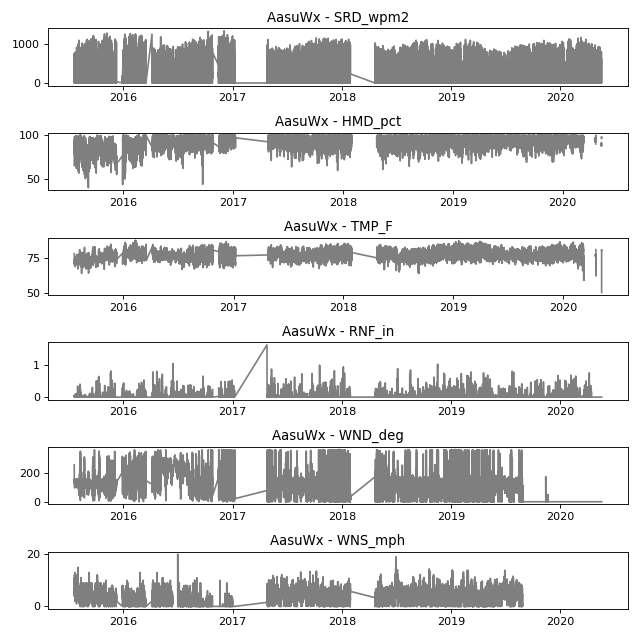

<IPython.core.display.Javascript object>


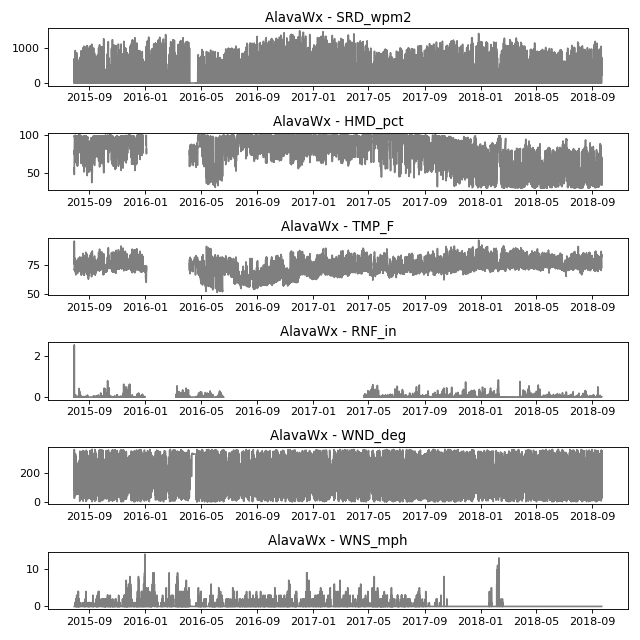

<IPython.core.display.Javascript object>


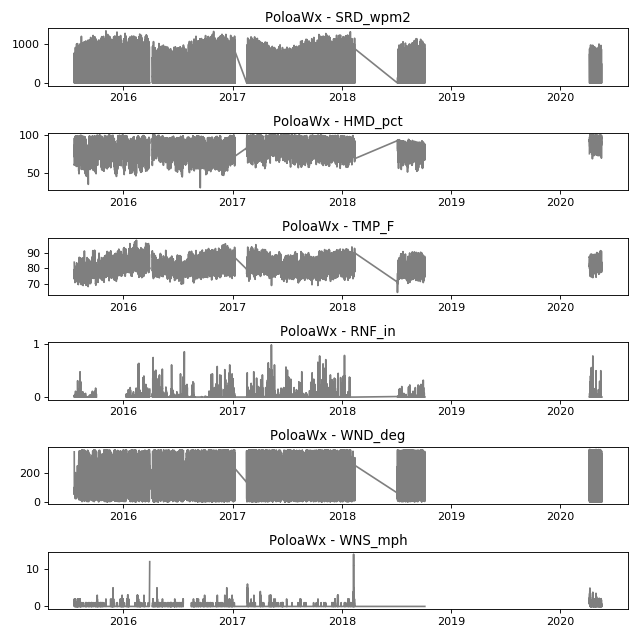

<IPython.core.display.Javascript object>


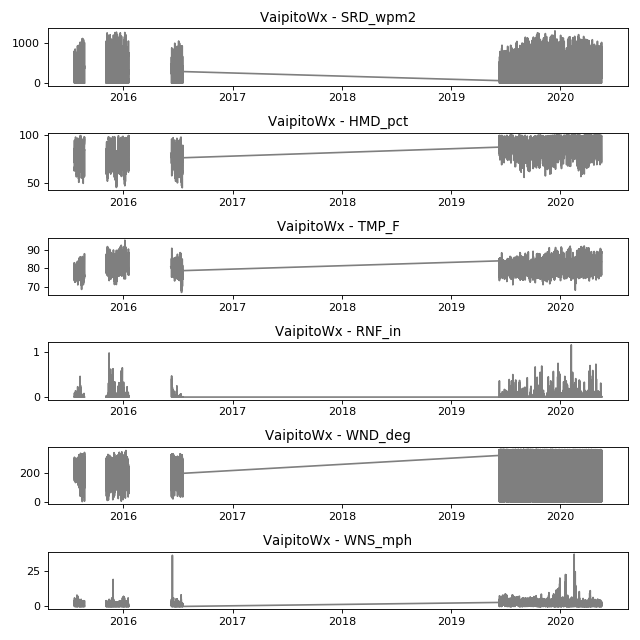

<IPython.core.display.Javascript object>


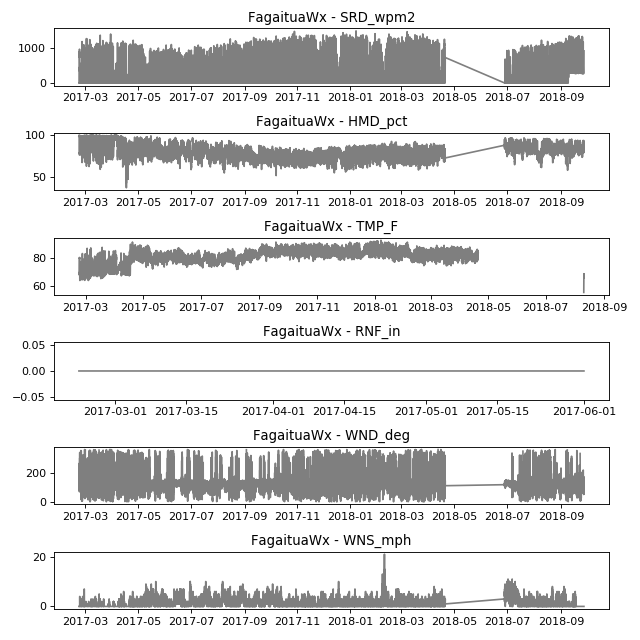

<IPython.core.display.Javascript object>


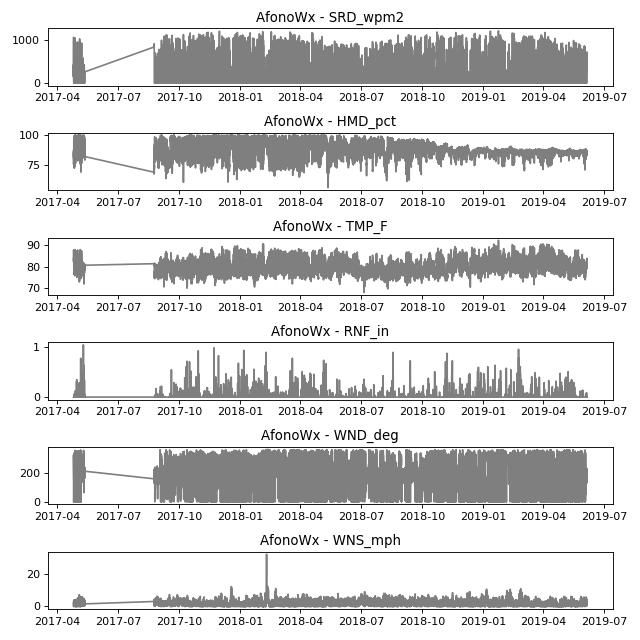

<IPython.core.display.Javascript object>


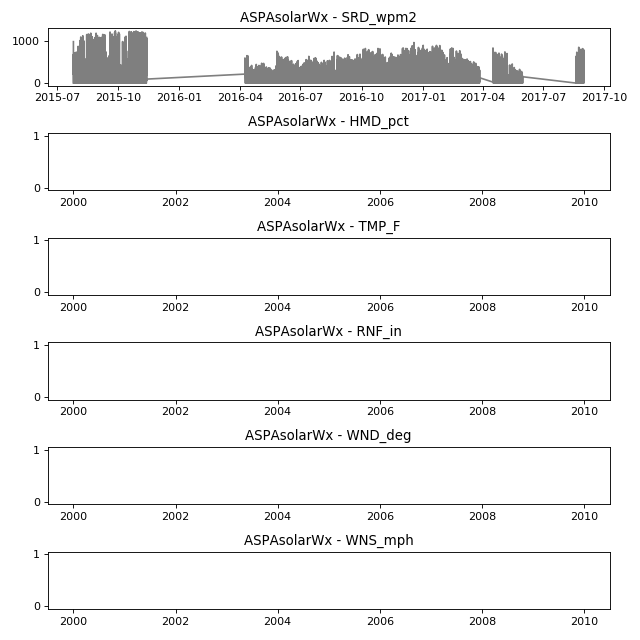

In [291]:
site_list = ['AasuWx', 'AlavaWx', 'PoloaWx', 'VaipitoWx', 'FagaituaWx', 'AfonoWx', 'ASPAsolarWx']

headings_no_date = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']


for site in site_list:
    data = QAmasters[site]

    # plot data by 
    fig, ax = plt.subplots(len(headings_no_date), 1, figsize=(8, 8))

    for idx, param in enumerate(headings_no_date):
        ax[idx].plot(data['DateTime'], data[param], alpha = .5, color='k', marker='')
        ax[idx].title.set_text("{} - {}".format(site, param))

    plt.tight_layout()
    plt.savefig(os.path.join("..", "Results", "Figures", "Weather", f"{site}_QAQC_All_Params.jpg"))
    

# Plot data to see whats going on
As currently set, the colored translucent data are each of the original files as processed by the initial processing step. the black data points are the QAQC data 

<IPython.core.display.Javascript object>


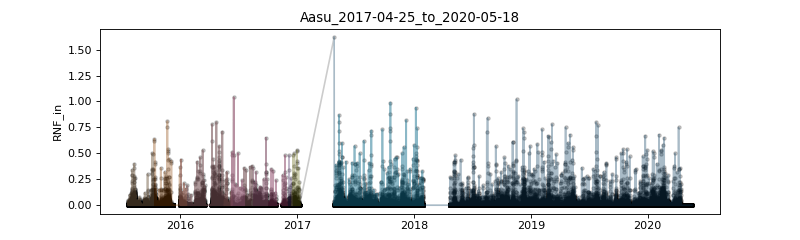

<IPython.core.display.Javascript object>


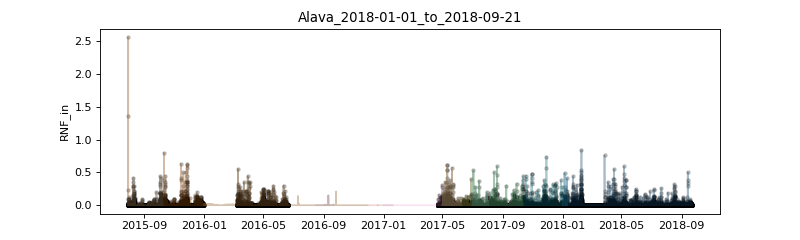

<IPython.core.display.Javascript object>


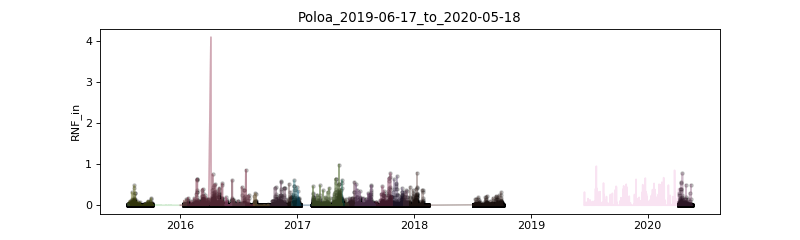

<IPython.core.display.Javascript object>


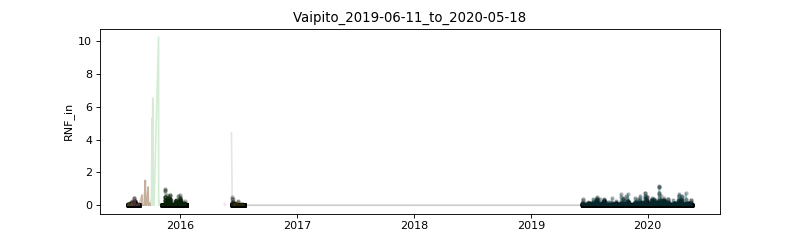

<IPython.core.display.Javascript object>


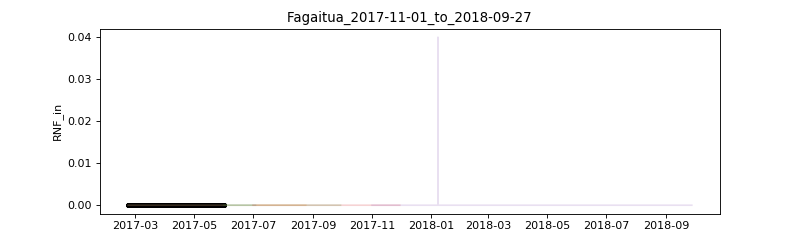

<IPython.core.display.Javascript object>


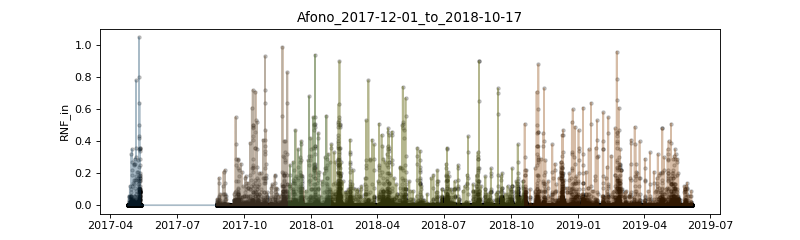

<IPython.core.display.Javascript object>


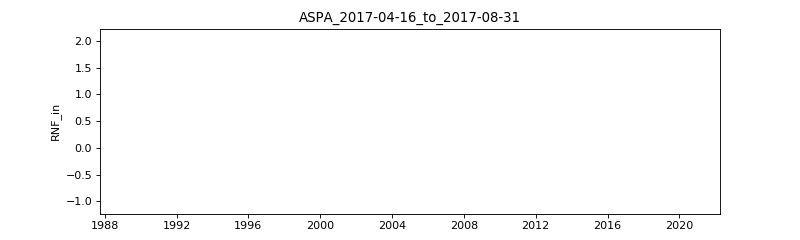

In [292]:
param = 'RNF_in'    # ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']      options

Da_list = ['AasuWx', 'AlavaWx', 'PoloaWx', 'VaipitoWx', 'FagaituaWx', 'AfonoWx', 'ASPAsolarWx']                                                             # remember the Wx dicts are groups of individual files...

# stations is a dictionary of dictionaries of the weather data files before and QA and QC
stations = {'AasuWx':AasuWx, 'AlavaWx':AlavaWx, 'PoloaWx':PoloaWx, 'VaipitoWx':VaipitoWx, 'FagaituaWx':FagaituaWx, 'AfonoWx':AfonoWx, 'ASPAsolarWx':ASPAsolarWx}        
#masters = {'AasuWx': AasuMaster, 'AlavaWx': AlavaMaster, 'PoloaWx': PoloaMaster,'VaipitoWx': VaipitoMaster, 'FagaituaWx':FagaituaMaster, 'AfonoWx':AfonoMaster} # this is a dictionary of all master data files
#note this is confusing, but the masters dictionary is a dictionary of the master_dataframes, has nothing to do with the groups (dicts) of individual files (Wx dictionaries) 
#but needs same name to plot within the loop.  The masters dictionary is remade below with keys that do not have that Wx ending

# plot the master files in black
try:
    for t in Da_list: 
        fig = plt.figure(figsize=(10, 3))
        ax1 = plt.axes()
        files = list(stations[t].keys())
        ax1.plot(QAmasters[t]['DateTime'], QAmasters[t][param], alpha = .2, color='k', marker='.')

        for i in files:    
            ax1.set_ylabel(param, color='k')
            plt.plot(stations[t][i]['DateTime'], stations[t][i][param], alpha = .2, label=i)
            ax1.set_title(i)

        #plt.xticks(rotation=20)
       # plt.tight_layout()

        plt.show()
        plt.savefig(os.path.join("..", "Results", "Figures", "Weather", "By_Parameter", f"{t}_QAQC_{param}.jpg"))
    
        
except: 
    pass

# Save all wx data as a Giant dataframe and csv

In [294]:
#This takes the Stations with the dates and figures out what the first and last dates are of all data in the folder         
# Then all the data can be put together into one file based on the FULL date range

# This is a lot of code to get the starting date from all the files, yes it is excessive... note does not do anything with data, just with the date range. 
splitter = lambda x: x.split("_")   # quick function to split each key name to parts
split_list = list(map(splitter, listos)); split_list    # apply the function to the list of file name keys (makes a list of lists) 
from itertools import chain
fitlist = list(chain.from_iterable(split_list))         # takes a list of lists and truns it into a list of the items
sortlist = sorted(fitlist)                              # sort it alphabetically 
dates_list = pd.to_datetime(sortlist, errors='coerce').dropna() # string date to real date and drop all the other words
start = dates_list[0]                                   # first date in the list
end = dates_list[-1] +timedelta(days=1)                 # last date in the list plus 1 day


#  this applies the make-a-list-of-consecutive-dates function on the start and end dates from the data in the folder  
Bigdatelist = []
for dt in datetime_range(start, end, {'minutes':15}):   # using above function make a list from start to end at whatever interval       
    Bigdatelist.append(dt)                              # stick each interval object onto a list 
labels = ['DateTime']                                  #define column name for dataframe
All_station_dates = pd.DataFrame(Bigdatelist, columns=labels)    # Make our list into a pd dataframe


Print_masters = {'Aasu': QAmasters['AasuWx'], 'Alava': QAmasters['AlavaWx'], 'Poloa': QAmasters['PoloaWx'],'Vaipito': QAmasters['VaipitoWx'], 'Fagaitua':QAmasters['FagaituaWx'], 'Afono':QAmasters['AfonoWx'], 'ASPAsolar':QAmasters['ASPAsolarWx']} # make a dictionary of all the master data files
for i in Print_masters: 
    Print_masters[i] = Print_masters[i].add_prefix(i+'_')  #Then add the prefix for the station ontoeach file
    date_col_nam = [col for col in Print_masters[i].columns if 'Date' in col]              # to effectivly merge them the prefix needs to be taken from the date. This matches any column with "date"
    Print_masters[i]= Print_masters[i].rename(columns = {str(date_col_nam[0]):'DateTime'}) # this renames that date column to DateTime plain and simple. 

#merge all the datasets into one massive dataset
All_merged = All_station_dates.merge(Print_masters['Aasu'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Alava'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Poloa'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Vaipito'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Fagaitua'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['Afono'], how='outer', on='DateTime')
All_merged = All_merged.merge(Print_masters['ASPAsolar'], how='outer', on='DateTime')

All_merged = All_merged[pd.notnull(All_merged['DateTime'])]        # drop any rows that dint have a date value

#all Merged is now the date aligned master dataset
All_merged.to_csv(os.path.join("..", "Results", 'QAQC_All_Weather_merged.csv'), index=False)